# 🟥 1. Introduction

## Netflix Titles — Exploratory Data Analysis (EDA)

This project analyzes the Netflix catalog dataset to understand patterns in content production, genres, ratings, release trends, and duration characteristics.

### Goals
- Clean and prepare the dataset.
- Engineer new useful features.
- Explore Netflix content trends.
- Extract actionable insights supported by visualizations.

The final cleaned dataset will be used in a Power BI Dashboard and shared as part of a Data Science portfolio project.


# 🟦 2. Importing Libraries

In [34]:
# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline

# Display formatting
from IPython.core.display import HTML
HTML("""
<style>
.dataframe table, .dataframe th, .dataframe td { font-size: 10px; }
div.output_scroll { overflow-x: auto; }
</style>
""")


# 🟩 3. Loading Dataset

In [35]:
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Quick Inspection
- Check dataset shape, info, and sample rows.
- Identify missing values or inconsistencies.


In [1]:
print("Dataset shape:", df.shape)
df.info()
df.sample(5)

NameError: name 'df' is not defined

# 🟨 4. Data Cleaning
## 4.1 Fixing date_added


In [37]:
df['date_added'] = df['date_added'].str.strip()
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['date_added'].isna().sum()
df = df.dropna(subset=['date_added'])

**Insight:** Ensures all date values are in datetime format, allowing time-based analysis like year_added or month_added.

## 4.2 Fixing rating & duration mix-ups

In [38]:
mask = df['rating'].str.contains('min', na=False)

minutes = df.loc[mask, 'rating'].str.extract(r'(\d+)')
df.loc[mask, 'duration'] = minutes[0] + " min"
df.loc[mask, 'rating'] = np.nan

**Insight:** Moves misplaced movie duration from rating to duration, cleaning the dataset for accurate analysis.

## 4.3 Filling Missing Values


In [39]:
df.fillna({
    'director': 'No Director Listed',
    'cast': 'No Cast Listed',
    'country': 'Unknown',
    'rating': 'Not rated'
}, inplace=True)

**Insight:** Prevents analysis errors due to missing data and makes summary statistics more reliable.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8797 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8797 non-null   object        
 1   type          8797 non-null   object        
 2   title         8797 non-null   object        
 3   director      8797 non-null   object        
 4   cast          8797 non-null   object        
 5   country       8797 non-null   object        
 6   date_added    8797 non-null   datetime64[ns]
 7   release_year  8797 non-null   int64         
 8   rating        8797 non-null   object        
 9   duration      8797 non-null   object        
 10  listed_in     8797 non-null   object        
 11  description   8797 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 893.4+ KB


## 4.4 Checking Duplicates

In [41]:
df.duplicated("show_id").sum()

np.int64(0)

**Insight:** Ensures each show has a unique identifier, avoiding double-counting in visualizations.

# 🟪 5. Feature Engineering
## 5.1 year_added + month_added

In [42]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

**Insight:** These new features allow more detailed EDA, like analyzing trends over time, duration, and age categories.

## 5.2 is_Recent (released after 2015)

In [43]:
df['is_Recent'] = (df['release_year'] >= 2015).astype(int)

**Insight:** `is_Recent`
 - This column distinguishes between recent titles (2015+) and older titles.  
 - It helps us understand whether the platform focuses more on new content or older content.  

## 5.3 category (Kids – Teens – Adults)

In [44]:
rating_groups = {
    'Kids': ['TV-Y','TV-Y7','TV-G','G','TV-Y7-FV'],
    'Teens': ['TV-PG','PG','PG-13','TV-14'],
    'Adults': ['TV-MA','R','NC-17','NR','UR']
}

rating_map = {r: cat for cat, ratings in rating_groups.items() for r in ratings}

df['category'] = df['rating'].map(rating_map).fillna('Unknown')

**Insight:** `category`
 - This column classifies titles by age group: Kids, Teens, Adults.  
 - It allows us to see which age group dominates the content.  
 - Useful in EDA to highlight content distribution trends.

## 5.4 duration_min & duration_seasons

In [45]:
df['duration_min'] = df['duration'].apply(lambda x: int(x.split()[0]) if 'min' in x else np.nan)
df['duration_seasons'] = df['duration'].apply(lambda x: int(x.split()[0]) if 'Season' in x else np.nan)

**Insight:** `duration_min` & `duration_seasons`
 - These columns convert textual duration into numeric values: movie duration in minutes and TV show duration in seasons.  
 - Also helps detect extremely short or long titles (outliers).

## 5.5 Extract main_genre

In [46]:
df['main_genre'] = df['listed_in'].str.split(',').str[0].str.strip()

**Insight:** `main_genre`
 - This column selects the primary genre of each title (the first in `listed_in`).  
 - It simplifies analyzing Top Genres without counting sub-genres multiple times.  

# 🟧 6. Exploratory Data Analysis (EDA)
Exploratory Data Analysis helps us understand the distribution, structure, and trends of Netflix content.

Below are the main visual explorations along with key insights.

In [47]:
# Display 10 random rows to get a quick overview of the dataset
df.sample(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,is_Recent,category,duration_min,duration_seasons,main_genre
138,s139,Movie,Dear John,Lasse Hallström,"Channing Tatum, Amanda Seyfried, Richard Jenki...",United States,2021-09-01,2010,PG-13,108 min,"Dramas, Romantic Movies","While on summer leave, a U.S. soldier falls fo...",2021,9,0,Teens,108.0,NaN,Dramas
5939,s5940,TV Show,The 4400,No Director Listed,"Joel Gretsch, Jacqueline McKenzie, Patrick Joh...","United States, United Kingdom",2013-09-01,2007,TV-14,4 Seasons,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",4400 people who vanished over the course of fi...,2013,9,0,Teens,NaN,4.0,TV Dramas
842,s843,TV Show,High on the Hog: How African American Cuisine ...,No Director Listed,No Cast Listed,Unknown,2021-05-26,2021,TV-14,1 Season,Docuseries,Black food is American food. Chef and writer S...,2021,5,1,Teens,NaN,1.0,Docuseries
4794,s4795,Movie,Duck Butter,Miguel Arteta,"Alia Shawkat, Laia Costa, Mae Whitman, Hong Ch...",United States,2018-07-01,2018,TV-MA,94 min,"Dramas, Independent Movies, LGBTQ Movies","Wary of dishonesty in relationships, two young...",2018,7,1,Adults,94.0,NaN,Dramas
2244,s2245,Movie,Hole in the Wall,"André Odendaal, Johan Vorster","André Odendaal, Nicholas Campbell, Tinarie van...",South Africa,2020-07-11,2016,TV-MA,104 min,"Dramas, International Movies","Diagnosed with colon cancer, a free-spirited m...",2020,7,1,Adults,104.0,NaN,Dramas
2824,s2825,TV Show,The Valhalla Murders,No Director Listed,"Nína Dögg Filippusdóttir, Björn Thors, Bergur ...",Iceland,2020-03-13,2020,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas",An Oslo detective with a painful past returns ...,2020,3,1,Adults,NaN,1.0,Crime TV Shows
644,s645,Movie,Good on Paper,Kimmy Gatewood,"Iliza Shlesinger, Ryan Hansen, Margaret Cho, R...",Unknown,2021-06-23,2021,TV-MA,94 min,"Comedies, Romantic Movies","After years of putting her career first, a sta...",2021,6,1,Adults,94.0,NaN,Comedies
184,s185,TV Show,Sparking Joy,No Director Listed,Marie Kondo,United States,2021-08-31,2021,TV-PG,1 Season,Reality TV,"In this reality series, Marie Kondo brings her...",2021,8,1,Teens,NaN,1.0,Reality TV
549,s550,TV Show,Big Timber,No Director Listed,No Cast Listed,Unknown,2021-07-02,2020,TV-14,1 Season,"International TV Shows, Reality TV",A no-nonsense logger and his loyal crew battle...,2021,7,1,Teens,NaN,1.0,International TV Shows
6059,s6060,Movie,A Tale of Love and Darkness,Natalie Portman,"Natalie Portman, Gilad Kahana, Amir Tessler, M...","Israel, United States",2019-10-25,2015,PG-13,98 min,"Dramas, International Movies","Based on the memoirs of author Amos Oz, this p...",2019,10,1,Teens,98.0,NaN,Dramas


## 6.1 Distribution of Type (Movies vs TV Shows)

In [50]:
# Count the number of Movies and TV Shows
type_counts = df['type'].value_counts()

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\2016344787.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set2")


<Figure size 600x400 with 0 Axes>

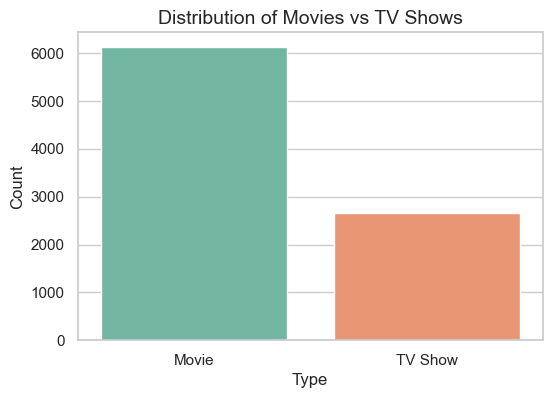

In [51]:
# Visualize the distribution of Movies vs TV Shows using a bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="Set2")
plt.title("Distribution of Movies vs TV Shows", fontsize=14)
plt.xlabel("Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

**Insight:** Movies make up the majority of Netflix content, roughly twice the number of TV Shows.


## 6.2 Distribution of Release Years

In [52]:
# Display basic statistics of release years
df['release_year'].describe().round()

count    8797.0
mean     2014.0
std         9.0
min      1925.0
25%      2013.0
50%      2017.0
75%      2019.0
max      2021.0
Name: release_year, dtype: float64

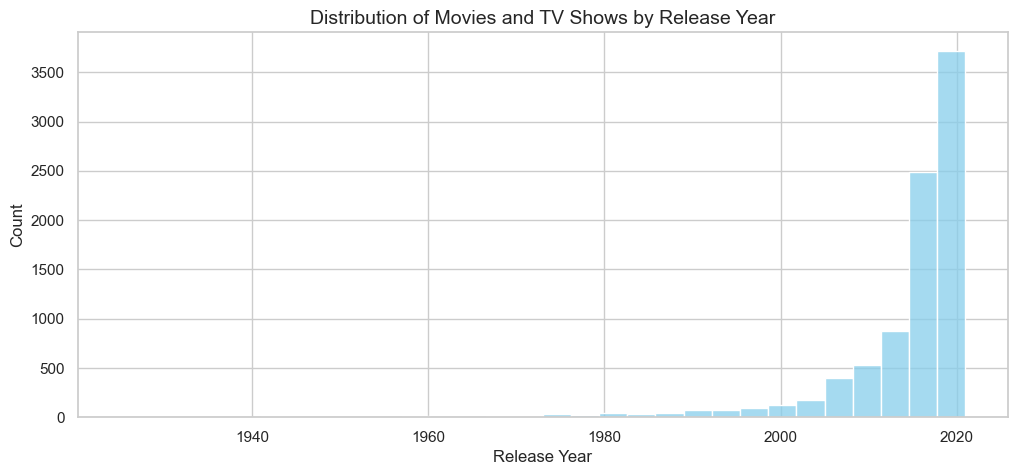

In [53]:
# Visualize the distribution of release years
plt.figure(figsize=(12,5))
sns.histplot(df['release_year'], bins=30, kde=False, color='skyblue')
plt.title("Distribution of Movies and TV Shows by Release Year", fontsize=14)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


**Insight:** The dataset strongly leans toward content released after 2010, reflecting Netflix’s rapid global expansion.


## 6.3 Recent vs Older

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\657773235.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recent_counts.index, y=recent_counts.values, palette='Set1')


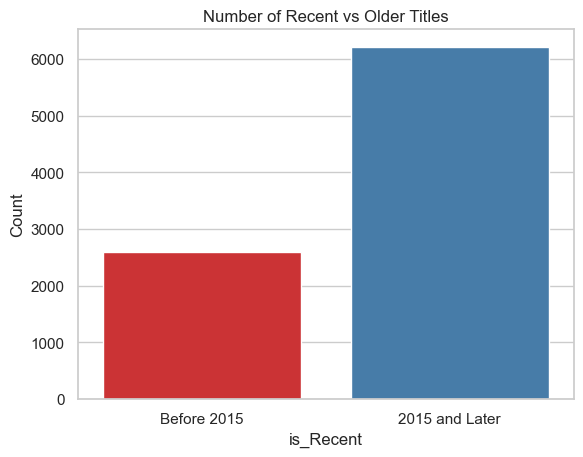

In [54]:
recent_counts = df['is_Recent'].value_counts()

sns.barplot(x=recent_counts.index, y=recent_counts.values, palette='Set1')
plt.xticks([0,1], ['Before 2015', '2015 and Later'])
plt.title("Number of Recent vs Older Titles")
plt.ylabel("Count")
plt.show()

**Insight:**  
The plot shows that the majority of titles on Netflix are recent (2015 and later).  
This indicates that Netflix maintains a modern library, frequently updating it with newer releases while featuring fewer older titles.


## 6.4 Year Added

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\4078557687.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=titles_per_year.index, y=titles_per_year.values, palette='viridis')


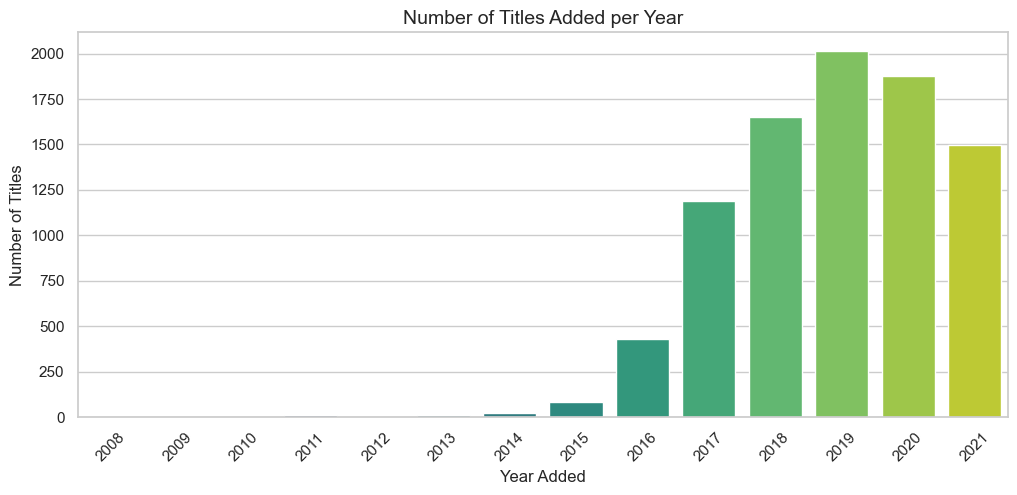

In [55]:
titles_per_year = df['year_added'].value_counts().sort_index()

plt.figure(figsize=(12,5))
sns.barplot(x=titles_per_year.index, y=titles_per_year.values, palette='viridis')
plt.title("Number of Titles Added per Year", fontsize=14)
plt.xlabel("Year Added", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.xticks(rotation=45)
plt.show()

**Insight:**  
Netflix saw a noticeable increase in the number of titles added starting around 2016–2019.  
This aligns with Netflix’s global expansion phase and increased investment in original content.  
The trend suggests aggressive growth during these years, followed by stabilization in recent additions.


## 6.5 Month Added

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\237163418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=titles_per_month.index, y=titles_per_month.values, palette='coolwarm')


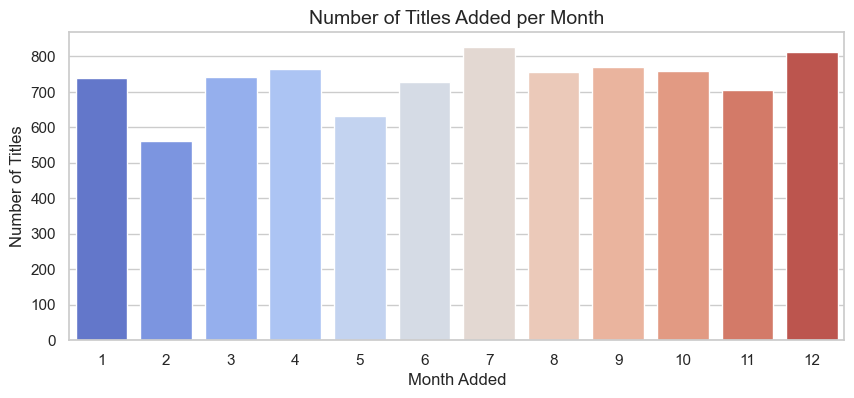

In [56]:
titles_per_month = df['month_added'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.barplot(x=titles_per_month.index, y=titles_per_month.values, palette='coolwarm')
plt.title("Number of Titles Added per Month", fontsize=14)
plt.xlabel("Month Added", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.show()


**Insight:**  
Netflix shows noticeable variation in monthly additions.  
Some months consistently receive more new titles, suggesting strategic release periods—possibly aligned with holidays, new seasons, or audience peaks.  
This monthly pattern helps us understand Netflix’s content scheduling behavior.


## 6.6 Top Producing Countries

In [57]:
# Count the number of titles per country and display the top 10
top_countries = df['country'].value_counts().head(10)
top_countries


country
United States     2812
India              972
Unknown            830
United Kingdom     418
Japan              244
South Korea        199
Canada             181
Spain              145
France             124
Mexico             110
Name: count, dtype: int64

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\529706190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="Set3")


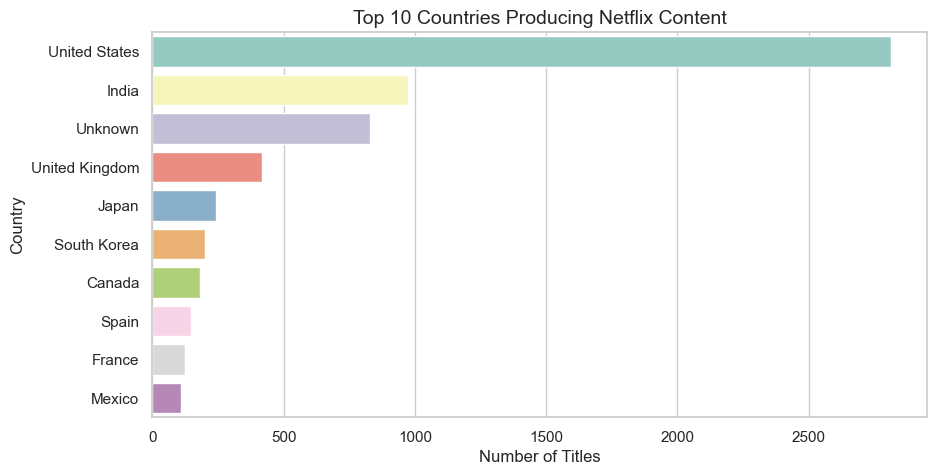

In [58]:
# Visualize the top 10 countries producing content
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Set3")
plt.title("Top 10 Countries Producing Netflix Content", fontsize=14)
plt.xlabel("Number of Titles", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.show()


**Insight:** The United States dominates Netflix production, followed by India and the UK.


## 6.7 Age Category Distribution

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\538646301.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, palette="Set3")


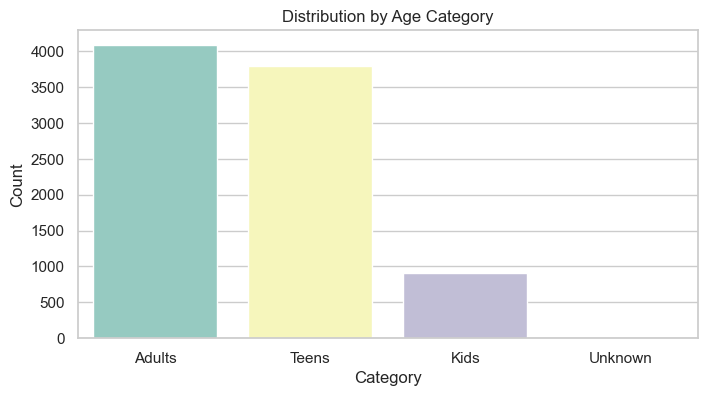

In [59]:
age_counts = df['category'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=age_counts.index, y=age_counts.values, palette="Set3")
plt.title("Distribution by Age Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


**Insight:** Most Netflix content is targeted toward Teens and Adults. Kids content is relatively limited.


## 6.8 Movie Duration Distribution

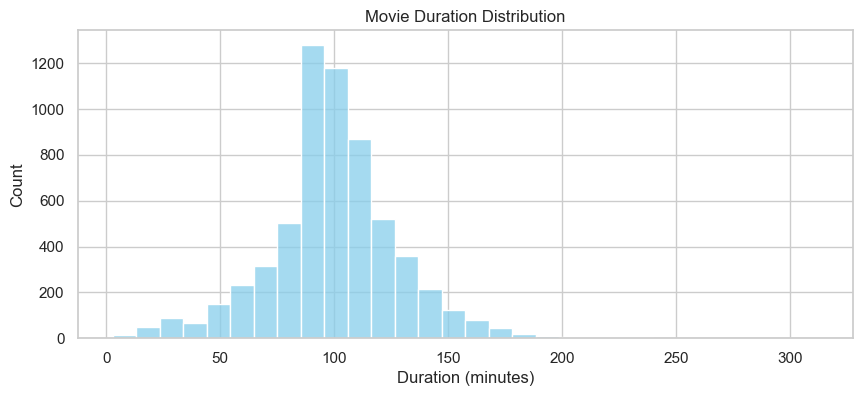

In [60]:
plt.figure(figsize=(10,4))
sns.histplot(df['duration_min'].dropna(), bins=30, color='skyblue')
plt.title("Movie Duration Distribution")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.show()


**Insight:** Most movies are between 80–120 minutes. Very short movies (under 10 minutes) are rare and often animated shorts.


## 6.9 TV Seasons Distribution

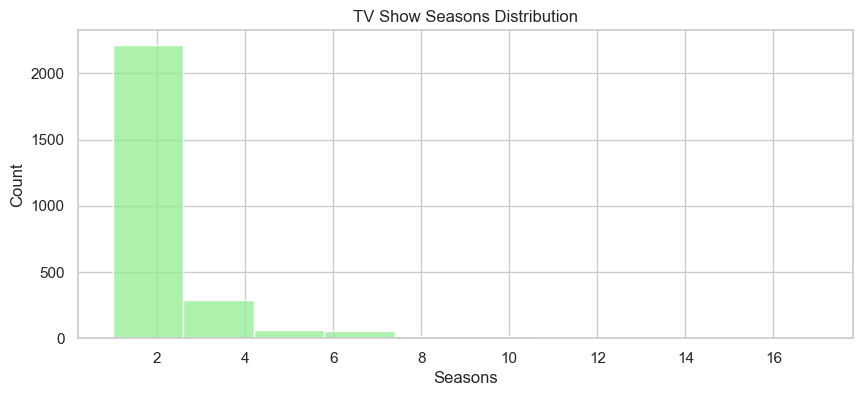

In [61]:
plt.figure(figsize=(10,4))
sns.histplot(df['duration_seasons'].dropna(), bins=10, color='lightgreen')
plt.title("TV Show Seasons Distribution")
plt.xlabel("Seasons")
plt.ylabel("Count")
plt.show()

**Insight:** Most TV shows run for 1–2 seasons. Very long series (5+ seasons) are uncommon.


## 6.10 Top Genres

C:\Users\qusay\AppData\Local\Temp\ipykernel_21780\1926946365.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


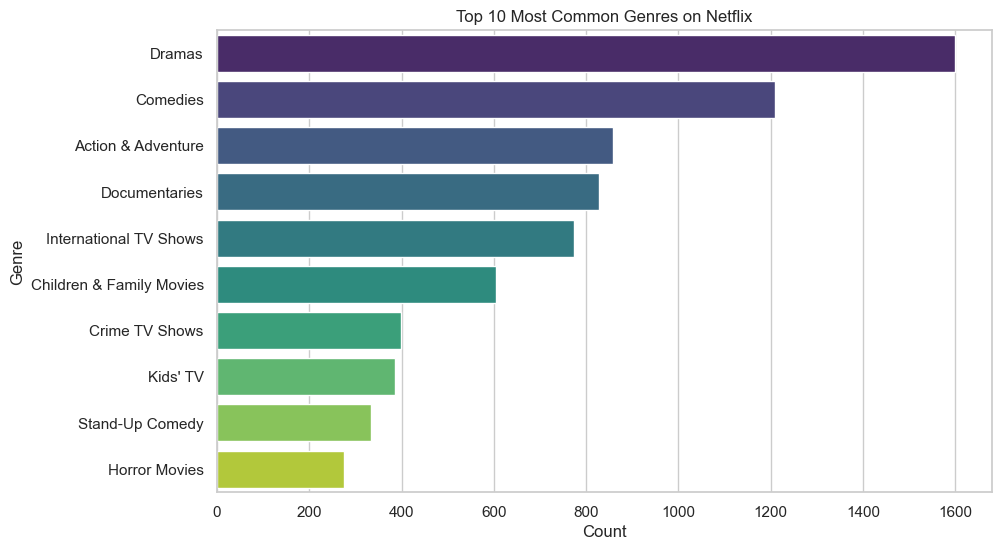

In [62]:
genre_counts = df['main_genre'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title("Top 10 Most Common Genres on Netflix")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


**Insight:** Drama and International Movies dominate Netflix content. Action, Comedy, and Family categories follow.


# 🟫 7. Export Final Clean Dataset

In [63]:
# Reorder columns for better readability and logical grouping
new_order = [
    'show_id', 'type', 'title',
    'main_genre', 'listed_in', 'description',
    'director', 'cast', 'country',
    'release_year', 'date_added', 'year_added', 'month_added',
    'rating', 'category', 'is_Recent',
    'duration', 'duration_min', 'duration_seasons'
]
df = df[new_order]

In [64]:
df.sample(10)

,show_id,type,title,main_genre,listed_in,description,director,cast,country,release_year,date_added,year_added,month_added,rating,category,is_Recent,duration,duration_min,duration_seasons
750,s751,Movie,Tragic Jungle,Dramas,"Dramas, Independent Movies, International Movies","To escape an arranged marriage, a woman flees ...",Yulene Olaizola,"Indira Andrewin, Gilberto Barraza, Gabino Rodr...","Mexico, France, Colombia",2021,2021-06-09,2021,6,TV-MA,Adults,1,97 min,97.0,NaN
4931,s4932,Movie,Pickpockets,Dramas,"Dramas, Independent Movies, International Movies",Aspiring teen thieves learn what it takes to b...,Peter Webber,"Carlos Bardem, Natalia Reyes, Emiliano Pernia,...",Colombia,2017,2018-04-12,2018,4,TV-MA,Adults,1,108 min,108.0,NaN
8637,s8638,Movie,Trumbo,Dramas,"Dramas, Independent Movies",When he is blacklisted by Hollywood for his le...,Jay Roach,"Bryan Cranston, Diane Lane, Elle Fanning, John...",United States,2015,2020-05-19,2020,5,R,Adults,1,124 min,124.0,NaN
8392,s8393,TV Show,The Liar,Crime TV Shows,"Crime TV Shows, International TV Shows, TV Dramas","At the CARE detective agency, investigators se...",No Director Listed,"Aenie Wong, Janelle Chin, Karena Teo, Goh Wee ...",Unknown,2013,2017-10-21,2017,10,TV-14,Teens,0,1 Season,NaN,1.0
4518,s4519,TV Show,The Haunting of Hill House,TV Dramas,"TV Dramas, TV Horror, TV Mysteries","Flashing between past and present, a fractured...",No Director Listed,"Michiel Huisman, Carla Gugino, Timothy Hutton,...",United States,2018,2018-10-12,2018,10,TV-MA,Adults,1,1 Season,NaN,1.0
8418,s8419,Movie,The Mayor,Dramas,"Dramas, International Movies","With the presidency in mind, the incumbent may...",Park In-je,"Min-sik Choi, Do-won Kwak, Eun-kyung Shim, So-...",South Korea,2017,2017-09-30,2017,9,TV-MA,Adults,1,130 min,130.0,NaN
6545,s6546,Movie,Cutie and the Boxer,Documentaries,Documentaries,A 2014 Oscar nominee for Best Documentary Feat...,Zachary Heinzerling,"Noriko Shinohara, Ushio Shinohara",United States,2013,2018-06-14,2018,6,R,Adults,0,82 min,82.0,NaN
8661,s8662,Movie,Unfinished Song,Comedies,"Comedies, Dramas, Independent Movies","With his wife terminally ill, Arthur's future ...",Paul Andrew Williams,"Terence Stamp, Gemma Arterton, Christopher Ecc...","United Kingdom, Germany",2012,2019-07-22,2019,7,PG-13,Teens,0,94 min,94.0,NaN
2181,s2182,TV Show,Transformers Rescue Bots Academy,Kids' TV,Kids' TV,As part of the first class at the Rescue Bots ...,No Director Listed,"Adam Andrianopolous, Pierce Cravens, Xander Cr...",United States,2020,2020-08-01,2020,8,TV-Y,Kids,1,2 Seasons,NaN,2.0
5841,s5842,Movie,Ip Man 3,Action & Adventure,"Action & Adventure, Dramas, International Movies",Martial arts master Ip springs into action whe...,Wilson Yip,"Donnie Yen, Zhang Jin, Lynn Hung, Patrick Tam,...","China, Hong Kong",2015,2016-06-18,2016,6,PG-13,Teens,1,105 min,105.0,NaN


In [65]:
df.to_csv("netflix_cleaned.csv", index=False)

**Note:** This cleaned dataset is ready for further analysis, modeling, or visualization.

# 🟦 8. Summary of Key Insights
## Summary of Insights

- Movies are significantly more common than TV Shows.
- Most content was released after 2010.
- The United States is the major contributor of Netflix content.
- Adult and Teen categories represent the majority of titles.
- Typical movie duration ranges between 80–120 minutes.
- Most TV shows have only 1–2 seasons.
- International and Drama genres are the most frequent.
